# 【問題1】公式チュートリアルモデルを分担して実行

RNN を使ったテキスト分類<br>
https://www.tensorflow.org/tutorials/text/text_classification_rnn

テンソルフローのデータセットをインポート<br>
IMDB 映画レビュー大型データセット（http://ai.stanford.edu/~amaas/data/sentiment/）

- tensorflow1.14で動作を確認(2.0では「tensorflow_datasets」が読みこめなかった)<br>
- tensorflow_datasetsのインストールが必要

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

入力パイプラインの設定<br>
- IMDB 映画レビュー大型データセットは"二値分類データセット"。<br>
- すべてのレビューは、好意的(positive) または 非好意的(negative) のいずれかの感情を含んでいる。<br>

In [4]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [5]:
encoder = info.features['text'].encoder

このテキストエンコーダーは、任意の文字列を可逆的にエンコードします。必要であればバイトエンコーディングでフォールバックできる。

In [6]:
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


- 今回のデータに含まれるユニークなVocabularyは８１８５種類（単語は全てID化される）

In [7]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [8]:
assert original_string == sample_string

- 'Hello TensorFlow.'は以下のように分割されID化されている

In [9]:
for index in encoded_string:
  print ('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


訓練用データの準備<br>
次に、これらのエンコード済み文字列をバッチ化します。<br>
padded_batch メソッドを使ってバッチ中の一番長い文字列の長さにゼロパディングを行います。<br>

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)

output_shapes_train = tf.compat.v1.data.get_output_shapes(train_dataset) #公式では記載ないためエラーになる
train_dataset = train_dataset.padded_batch(BATCH_SIZE,output_shapes_train) #output_shapes_trainを引数に追加

output_shapes_test = tf.compat.v1.data.get_output_shapes(test_dataset)  #公式では記載ないためエラーになる
test_dataset = test_dataset.padded_batch(BATCH_SIZE,output_shapes_test) #output_shapes_testを引数に追加

リカレントニューラルネットワーク（RNN）は、シーケンスの入力を要素を一つずつ扱うことで処理します。<br>
RNN は、あるタイムステップでの出力を次のタイムステップの入力へと、次々に渡していきます。<br>
RNN レイヤーとともに、tf.keras.layers.Bidirectional ラッパーを使用することができます。<br>
このラッパーは、入力を RNN 層の順方向と逆方向に伝え、その後出力を結合します。<br>
これにより、RNN は長期的な依存関係を学習できます。<br>

Embedding = 単語を数値化する<br>
Bidirectional =入出力の双方向に学習？
LSTM(64) = 短期長期記憶をメモリに保存（）内のパラメーターで保存する容量を決定？

LSTM→FC→FC

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

訓練プロセスを定義するため、Keras モデルをコンパイルします。

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

時間短縮のためエポックは１０→５に減らして計算

In [14]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/5
391/391 [==============================] - 583s 1s/step - loss: 0.6127 - accuracy: 0.6435 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
391/391 [==============================] - 583s 1s/step - loss: 0.3276 - accuracy: 0.8695 - val_loss: 0.3412 - val_accuracy: 0.8661
Epoch 3/5
391/391 [==============================] - 649s 2s/step - loss: 0.2498 - accuracy: 0.9070 - val_loss: 0.3189 - val_accuracy: 0.8771
Epoch 4/5
391/391 [==============================] - 683s 2s/step - loss: 0.2068 - accuracy: 0.9265 - val_loss: 0.3414 - val_accuracy: 0.8776
Epoch 5/5
391/391 [==============================] - 692s 2s/step - loss: 0.1798 - accuracy: 0.9372 - val_loss: 0.3450 - val_accuracy: 0.8766


上記のモデルはシーケンスに適用されたパディングをマスクしていません。

In [15]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 138s 354ms/step - loss: 0.3566 - accuracy: 0.8678
Test Loss: 0.3566382362714509
Test Accuracy: 0.8678399920463562


In [16]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [56]:
def sample_predict(sentence, pad):
  encoded_sample_pred_text = encoder.encode(sentence) #公式のコードから修正

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

レビュー内容「映画はクールでした。 アニメーションとグラフィックスは飛び抜けていた。 この映画をお勧めします。」

In [57]:
# パディングなしのサンプルテキストの推論(ポジティブ)
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.4999575]]


In [58]:
# パディングありのサンプルテキストの推論(ポジティブ)
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.48828924]]


In [60]:
# パディングなしのサンプルテキストの推論(ネガティブ)
sample_pred_text = ('The movie was not cool. The animation and the graphics '
                    'were out of this world. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.39679363]]


In [61]:
# パディングありのサンプルテキストの推論(ネガティブ)
sample_pred_text = ('The movie was not cool. The animation and the graphics '
                    'were out of this world. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.3861104]]


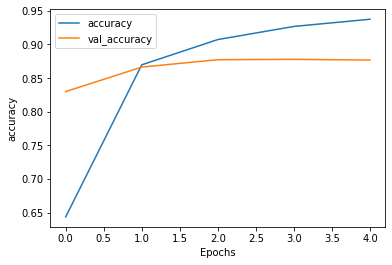

In [20]:
plot_graphs(history, 'accuracy')

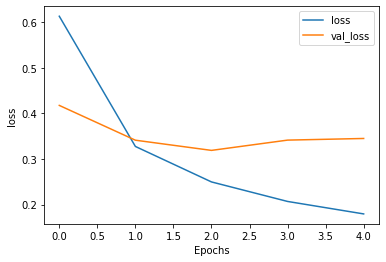

In [21]:
plot_graphs(history, 'loss')

2つ以上の LSTM レイヤーを重ねる<br>
Keras のリカレントレイヤーには、コンストラクタの return_sequences 引数でコントロールされる2つのモードがあります。<br>
それぞれのタイムステップの連続した出力のシーケンス全体（shape が (batch_size, timesteps, output_features) の3階テンソル）を返す。<br>
それぞれの入力シーケンスの最後の出力だけ（shape が (batch_size, output_features) の2階テンソル）を返す。<br>

LSTM（６４）→LSTM（３２）→FC（ドロップアウト）→FC<br>
1番目のLSTMでは「A,B,C,Dの4つがあったら、A, B, C=>Dだけでなく、A=>B、A,B=>Cも学習する設定になっている」

In [23]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [24]:
model2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

時間短縮のためエポック数は１０→５に減らして計算

In [26]:
history2 = model2.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
391/391 [==============================] - 1244s 3s/step - loss: 0.5917 - accuracy: 0.6704 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
391/391 [==============================] - 1190s 3s/step - loss: 0.3393 - accuracy: 0.8712 - val_loss: 0.3555 - val_accuracy: 0.8552
Epoch 3/5
391/391 [==============================] - 1074s 3s/step - loss: 0.2499 - accuracy: 0.9119 - val_loss: 0.3588 - val_accuracy: 0.8490
Epoch 4/5
391/391 [==============================] - 1145s 3s/step - loss: 0.2205 - accuracy: 0.9248 - val_loss: 0.3602 - val_accuracy: 0.8651
Epoch 5/5
391/391 [==============================] - 1168s 3s/step - loss: 0.1748 - accuracy: 0.9467 - val_loss: 0.3709 - val_accuracy: 0.8542


In [27]:
test_loss2, test_acc2 = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss2))
print('Test Accuracy: {}'.format(test_acc2))

391/391 [==============================] - 249s 637ms/step - loss: 0.3664 - accuracy: 0.8543
Test Loss: 0.36644667318409974
Test Accuracy: 0.8543199896812439


In [50]:
def sample_predict2(sentence, pad):
  encoded_sample_pred_text = encoder.encode(sentence) #公式のコードから修正

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model2.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

レビュー内容「映画は良くなかった。 アニメーションとグラフィックスがひどかった。 この映画はお勧めしません。」

In [51]:
# パディングなしのサンプルテキストの推論(ネガティブ)
sample_pred_text2 = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions2 = sample_predict2(sample_pred_text2, pad=False)
print (predictions2)

[[0.22510944]]


In [52]:
# パディングなしのサンプルテキストの推論(ネガティブ)
sample_pred_text3 = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions3 = sample_predict2(sample_pred_text3, pad=True)
print (predictions3)

[[0.06083976]]


In [68]:
# パディングなしのサンプルテキストの推論(ポジティブ)
sample_pred_text6 = ('The movie was great. The animation and the graphics were beautful. I would recommend this movie.')
predictions6 = sample_predict2(sample_pred_text6, pad=False)
print (predictions6)

[[0.65984386]]


In [69]:
# パディングありのサンプルテキストの推論(ポジティブ)
sample_pred_text7 = ('The movie was great. The animation and the graphics were beautful. I would recommend this movie.')
predictions7 = sample_predict2(sample_pred_text7, pad=True)
print (predictions7)

[[0.5045866]]


In [71]:
# パディングなしのサンプルテキストの推論(ポジティブ)
sample_pred_text7 = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions7 = sample_predict2(sample_pred_text7, pad=False)
print (predictions7)

[[0.59869426]]


In [72]:
# パディングありのサンプルテキストの推論(ポジティブ)
sample_pred_text7 = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions7 = sample_predict2(sample_pred_text7, pad=True)
print (predictions7)

[[0.39874557]]


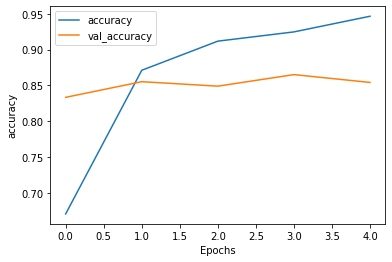

In [35]:
plot_graphs(history2, 'accuracy')

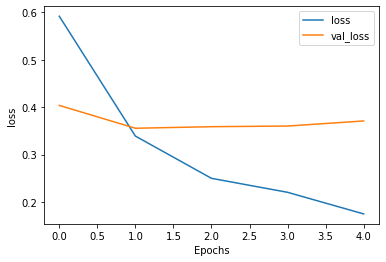

In [36]:
plot_graphs(history2, 'loss')